In [81]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from glob import glob

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter,white_signals,gp_signals,signal_base
from enterprise.signals.utils import powerlaw

from enterprise_extensions import blocks
from enterprise_extensions.model_utils import get_tspan

from la_forge.core import Core

import sys
sys.path.append('../')
sys.path.append('../../PerFreqOS')

from OSplusplus import OSplusplus
from OSplusplus import utils

from PFOS.optimal_statistic import OptimalStatistic
from PFOS.pfos_functions import compute_normPFOS, compute_radPFOS
from PFOS.psr_pair_covariance import pair_covariant_OS, pair_covariant_normPFOS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load up MDC1 pulsars and CURN PTA

In [2]:
datadir = enterprise.__path__[0] + '/datafiles/mdc_open1/'
parfiles = sorted(glob(datadir + '/*.par'))
timfiles = sorted(glob(datadir + '/*.tim'))

psrs = [Pulsar(par,tim) for par,tim in zip(parfiles,timfiles)]

inj_params = {'gw_log10_A':np.log10(5e-14),'gw_gamma':(13./3.)}

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [3]:
Tspan = get_tspan(psrs)

efac = parameter.Constant(1.0)
ef = white_signals.MeasurementNoise(efac=efac)

curn = blocks.common_red_noise_block(psd='powerlaw',Tspan=Tspan,components=10,
                                     gamma_val=13./3.,logmin=-18,logmax=-12,name='gw')

tm = gp_signals.TimingModel(use_svd=True)

model = tm + ef + curn

pta = signal_base.PTA([model(psr) for psr in psrs])

lfcore_loc = 'MDC1_FG_CURN_samples.core'
lfcore = Core(corepath=lfcore_loc)

Loading data from HDF5 file....


In [164]:
# A handy function to take the percent difference between elements

def minmax_percent_diff(true,test):
    """Get the minimum and maximum percent difference of the elements (test-true)/true"""
    temp = np.abs(test-true)/true
    return np.min(temp),np.max(temp)




xi_range = np.linspace(0.01,np.pi,1000)
hd_cor = utils.orf_xi(xi_range,'hd')
dp_cor = utils.orf_xi(xi_range,'dipole')
mp_cor = utils.orf_xi(xi_range,'monopole')


## Create an older OS object and a new OS++ object

In [165]:
old_os = OptimalStatistic(psrs,pta=pta)

new_os = OSplusplus(psrs,pta,'gw',core=lfcore)

#### Traditional OS

(0.0, 0.0)
(-5.261740541901247e-11, 2.370886507735983e-10)
(0.0, 1.2888122522517395e-15)
(2.285169816469709e-13, 2.285169816469709e-13)
(1.1745032123349341e-16, 1.1745032123349341e-16)


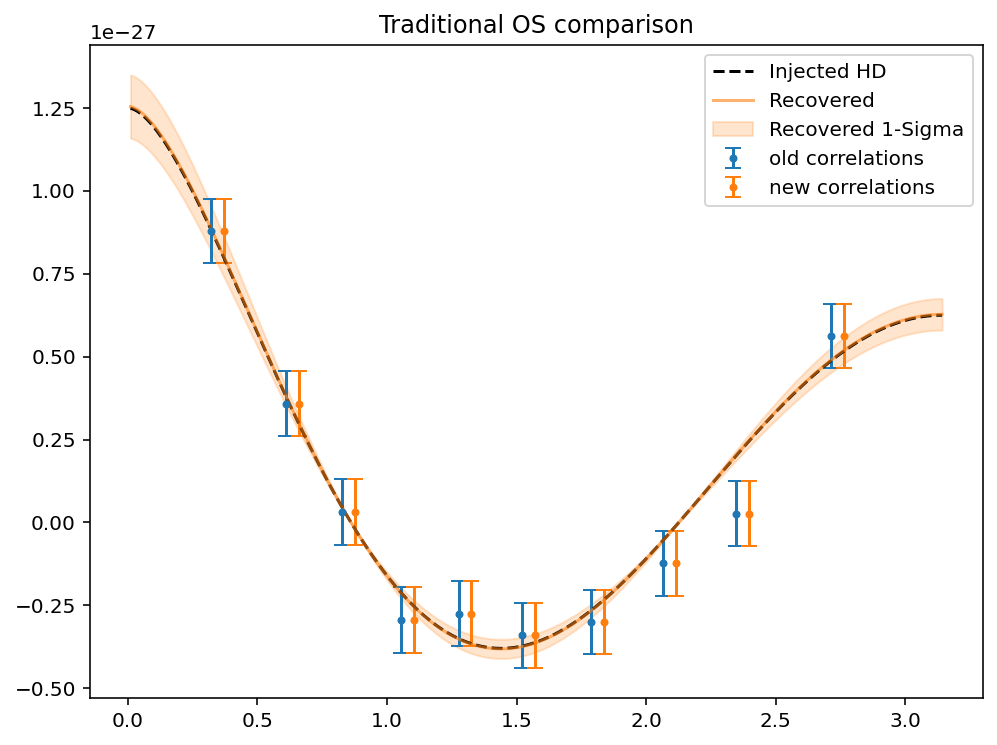

In [166]:
old_xi,old_rho,old_sig,old_A2,old_A2s = old_os.compute_os(inj_params)

xi,rho,sig,C,A2,A2s = new_os.compute_OS(inj_params, pair_covariance=False, save_pair_vals=True)

# Print differences
print(minmax_percent_diff(old_xi,xi))
print(minmax_percent_diff(old_rho,rho))
print(minmax_percent_diff(old_sig,sig))
print(minmax_percent_diff(old_A2,A2))
print(minmax_percent_diff(old_A2s,A2s))

# Plots
plt.figure(figsize=(8,6))

xia,rhoa,siga = utils.binned_pair_correlations(old_xi,old_rho,old_sig,10)
plt.errorbar(xia,rhoa,siga,fmt='.',capsize=4,label='old correlations')

xia,rhoa,siga = utils.binned_pair_correlations(xi,rho,sig,10)
plt.errorbar(xia+0.05,rhoa,siga,fmt='.',capsize=4,label='new correlations')

plt.plot(xi_range,(5e-14)**2*hd_cor,'--k',label='Injected HD')

plt.plot(xi_range,A2*hd_cor,'-C1',alpha=0.6,label='Recovered')
plt.fill_between(xi_range,(A2-A2s)*hd_cor,(A2+A2s)*hd_cor,color='C1',alpha=0.2,
                 label='Recovered 1-Sigma')

plt.title('Traditional OS comparison')
plt.legend()
plt.show()

#### Pair Covariant OS

Pairs of pairs: 100%|███████████████| 198765/198765 [00:00<00:00, 505777.31it/s]


(0.0, 0.0)
(-5.261740541901247e-11, 2.370886507735983e-10)
(-2.710518856842176e-14, 1.0806158223254641e-13)
(4.4950895683325914e-13, 4.4950895683325914e-13)
(5.178084475722463e-16, 5.178084475722463e-16)


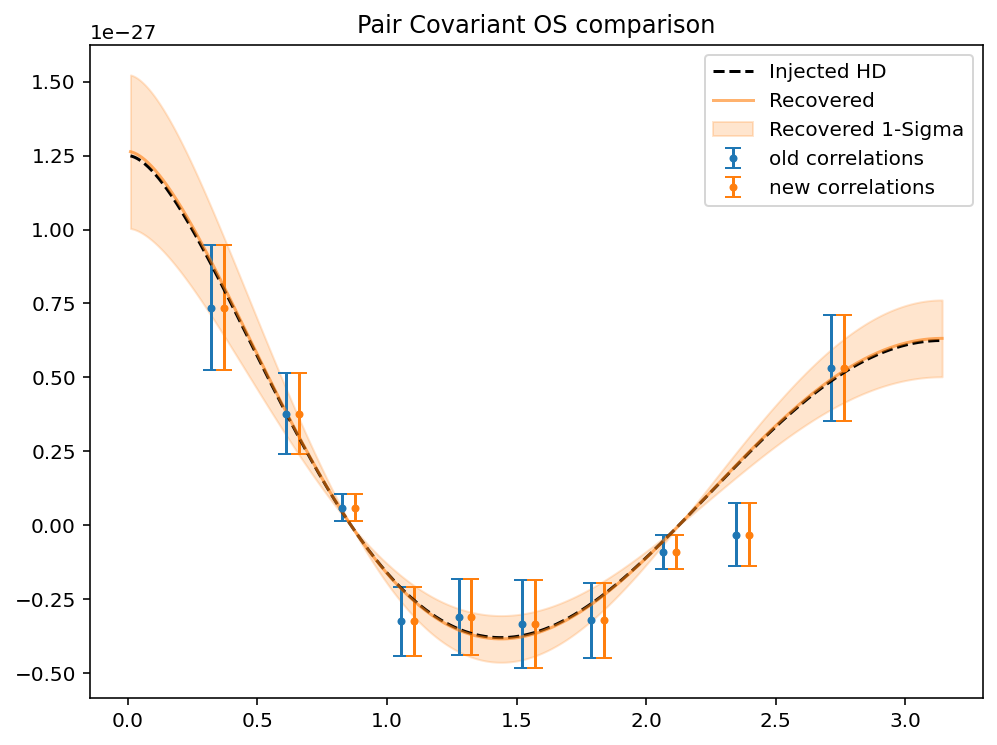

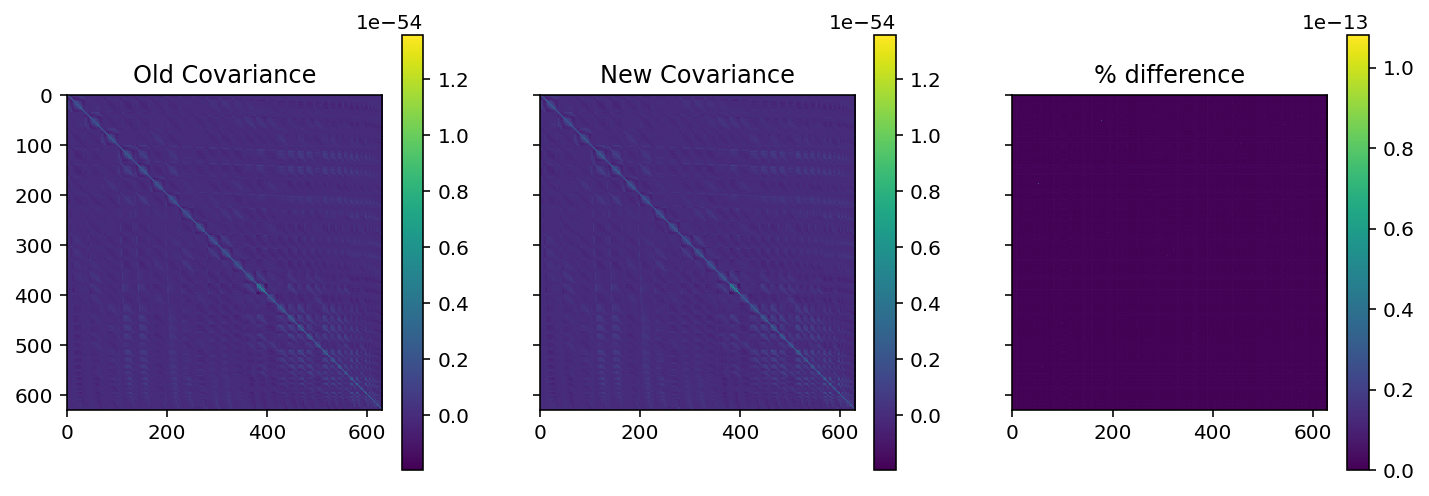

In [167]:
old_xi,old_rho,old_sig,old_A2,old_A2s = pair_covariant_OS(old_os,inj_params)

xi,rho,sig,C,A2,A2s = new_os.compute_OS(inj_params, pair_covariance=True, save_pair_vals=True)

# Print differences
print(minmax_percent_diff(old_xi,xi))
print(minmax_percent_diff(old_rho,rho))
print(minmax_percent_diff(old_sig,C))
print(minmax_percent_diff(old_A2,A2))
print(minmax_percent_diff(old_A2s,A2s))

# Plots
plt.figure(figsize=(8,6))

xia,rhoa,siga = utils.binned_pair_covariant_correlations(old_xi,old_rho,old_sig,10)
plt.errorbar(xia,rhoa,siga,fmt='.',capsize=4,label='old correlations')

xia,rhoa,siga = utils.binned_pair_covariant_correlations(xi,rho,C,10)
plt.errorbar(xia+0.05,rhoa,siga,fmt='.',capsize=4,label='new correlations')

plt.plot(xi_range,(5e-14)**2*hd_cor,'--k',label='Injected HD')

plt.plot(xi_range,A2*hd_cor,'-C1',alpha=0.6,label='Recovered')
plt.fill_between(xi_range,(A2-A2s)*hd_cor,(A2+A2s)*hd_cor,color='C1',alpha=0.2,
                 label='Recovered 1-Sigma')

plt.title('Pair Covariant OS comparison')
plt.legend()
plt.show()

# Plot the covariance matrix
fig, ax = plt.subplots(1,3,sharey=True,figsize=(12,4))
img = ax[0].imshow(old_sig)
fig.colorbar(img)
ax[0].set_title('Old Covariance')

img = ax[1].imshow(C)
ax[1].set_title('New Covariance')
fig.colorbar(img)

img = ax[2].imshow(np.abs((C-old_sig)/old_sig))
ax[2].set_title('% difference')
fig.colorbar(img)

plt.show()

#### MCOS

(0.0, 0.0)
(-5.261740541901247e-11, 2.370886507735983e-10)
(0.0, 1.2888122522517395e-15)
(-3.668139124287212e-13, 6.708782990470634e-12)
(1.1375008687035544e-16, 2.234484892986085e-16)


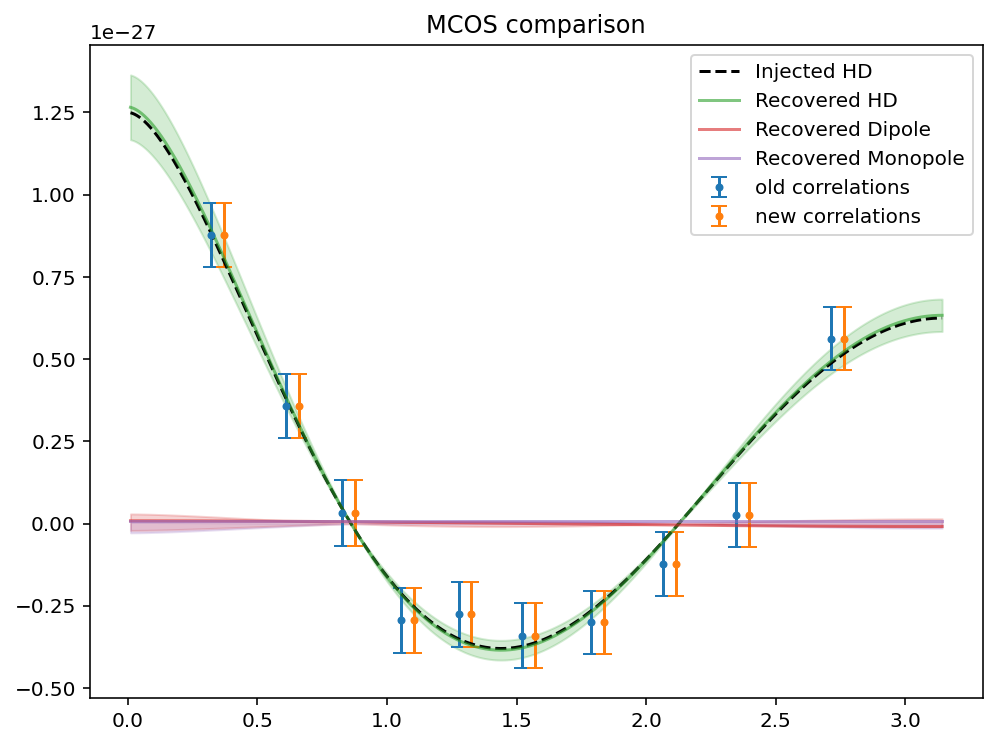

In [170]:
old_xi,old_rho,old_sig,old_A2,old_A2s = old_os.compute_multiple_corr_os(inj_params,
                                            correlations=['hd','dipole','monopole'])

new_os.set_orf(['hd','dipole','monopole'])
xi,rho,sig,C,A2,A2s = new_os.compute_OS(inj_params, pair_covariance=False, save_pair_vals=True)
new_os.set_orf('hd')

# Print differences
print(minmax_percent_diff(old_xi,xi))
print(minmax_percent_diff(old_rho,rho))
print(minmax_percent_diff(old_sig,sig))
print(minmax_percent_diff(old_A2,A2))
print(minmax_percent_diff(old_A2s,np.sqrt(np.diag(A2s))))


# Plots
plt.figure(figsize=(8,6))

xia,rhoa,siga = utils.binned_pair_correlations(old_xi,old_rho,old_sig,10)
plt.errorbar(xia,rhoa,siga,fmt='.',capsize=4,label='old correlations')

xia,rhoa,siga = utils.binned_pair_correlations(xi,rho,sig,10)
plt.errorbar(xia+0.05,rhoa,siga,fmt='.',capsize=4,label='new correlations')

plt.plot(xi_range,(5e-14)**2*hd_cor,'--k',label='Injected HD')

plt.plot(xi_range,A2[0]*hd_cor,'-C2',alpha=0.6,label='Recovered HD')
plt.fill_between(xi_range,
                 (A2[0]-np.sqrt(A2s[0,0]))*hd_cor,
                 (A2[0]+np.sqrt(A2s[0,0]))*hd_cor,
                 color='C2',alpha=0.2)
plt.plot(xi_range,A2[1]*dp_cor,'-C3',alpha=0.6,label='Recovered Dipole')
plt.fill_between(xi_range,
                 (A2[1]-np.sqrt(A2s[1,1]))*hd_cor,
                 (A2[1]+np.sqrt(A2s[1,1]))*hd_cor,
                 color='C3',alpha=0.2)
plt.plot(xi_range,A2[1]*mp_cor,'-C4',alpha=0.6,label='Recovered Monopole')
plt.fill_between(xi_range,
                 (A2[2]-np.sqrt(A2s[2,2]))*hd_cor,
                 (A2[2]+np.sqrt(A2s[2,2]))*hd_cor,
                 color='C4',alpha=0.2)

plt.title('MCOS comparison')
plt.legend()
plt.show()

#### NMOS with traditional OS

In [179]:
_,_,_,old_A2,old_A2s = old_os.compute_noise_marginalized_os(chain=lfcore.chain,
                                                            param_names=lfcore.params,
                                                            N=10000)

A2,A2s,idx = new_os.compute_OS(N=10000,pair_covariance=False)

/Users/gersbaka/Documents/Projects/OSplusplus/Notebooks/../../PerFreqOS/PFOS/optimal_statistic.py:163: UserWarning: MCMC chain does not have the same number of parameters as the model.
100%|██████████| 10000/10000 [01:14<00:00, 134.46it/s]


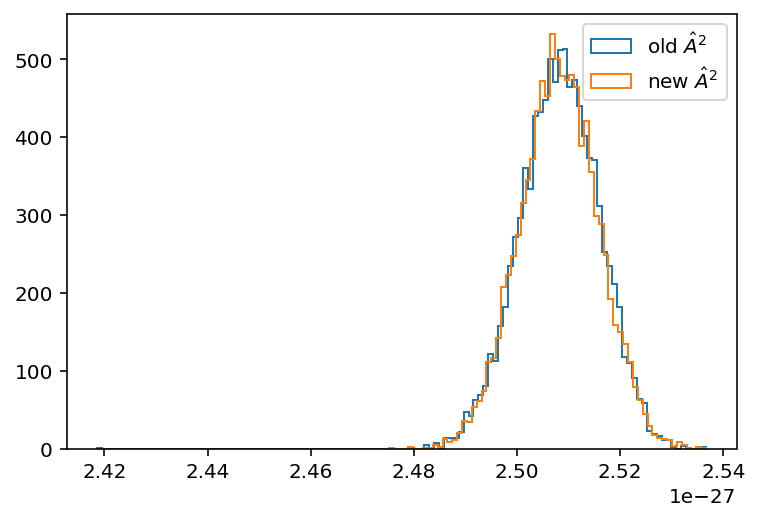

In [180]:
plt.hist(old_A2,bins='auto',histtype='step',label='old $\hat{A}^2$')
plt.hist(A2,bins='auto',histtype='step',label='new $\hat{A}^2$')
plt.legend()
plt.show()

100%|██████████| 10/10 [00:00<00:00, 1778.08it/s]


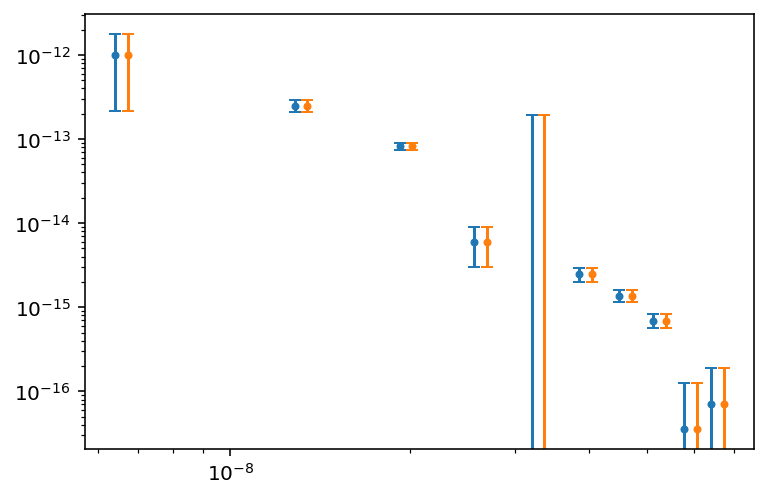

In [68]:
old_xi,old_rhok,old_sigk,old_Sk,old_Sks,fgw = compute_radPFOS(old_os,inj_params)
plt.errorbar(fgw,old_Sk,old_Sks,fmt='.',capsize=3)

xi,rhok,sigk,Ck,Sk,Sks = t1.compute_pfos(inj_params,pair_covariance=False,narrowband=True,save_pair_vals=True)
plt.errorbar(t1.freqs+t1.freqs/20,Sk,Sks,fmt='.',capsize=3)

plt.loglog()
plt.show()

100%|██████████| 10/10 [00:00<00:00, 1717.64it/s]


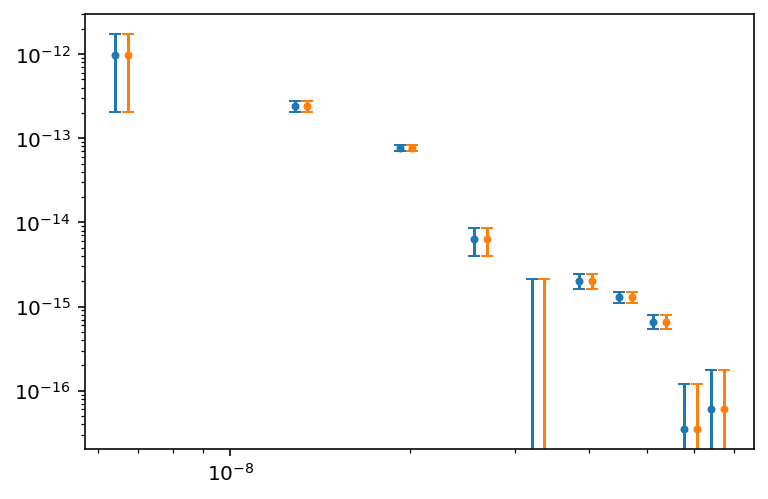

[ 1.2666663   6.19724587 11.0292941   2.72035991 -0.09853658  4.91262315
  6.24202156  5.29190759  0.40563302  0.5400501 ]
[ 1.2666663   6.19724587 11.0292941   2.72035991 -0.09853658  4.91262315
  6.24202156  5.29190759  0.40563302  0.5400501 ]


In [69]:
old_xi,old_rhok,old_sigk,old_Sk,old_Sks,fgw = compute_normPFOS(old_os,inj_params)
plt.errorbar(fgw,old_Sk,old_Sks,fmt='.',capsize=3)

xi,rhok,sigk,Ck,Sk,Sks = t1.compute_pfos(inj_params,pair_covariance=False,narrowband=False,save_pair_vals=True)
plt.errorbar(t1.freqs+t1.freqs/20,Sk,Sks,fmt='.',capsize=3)

plt.loglog()
plt.show()

print(old_Sk/old_Sks)
print(Sk/Sks)

100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


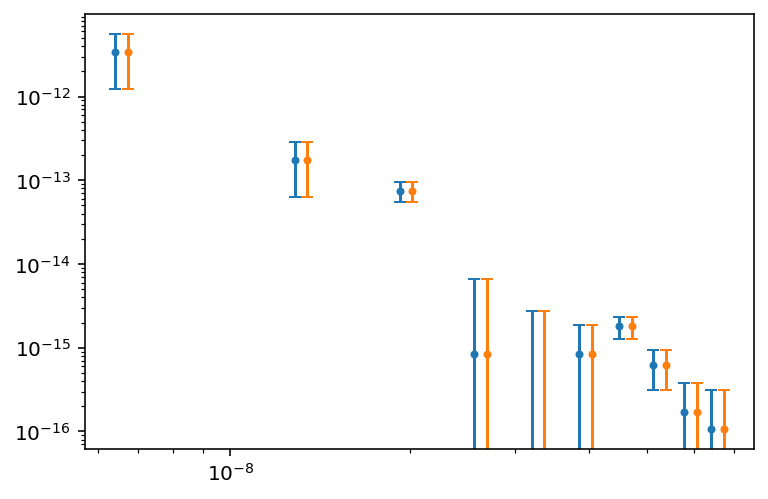

[ 1.55705234  1.56714773  3.87255614  0.14542263 -0.19039116  0.81465592
  3.33859252  1.99888672  0.83768398  0.52521374]
[ 1.55705234  1.56714773  3.87255614  0.14542263 -0.19039116  0.81465592
  3.33859252  1.99888672  0.83768398  0.52521374]


In [70]:
old_xi,old_rhok,old_sigk,old_Sk,old_Sks,fgw = pair_covariant_normPFOS(old_os,inj_params)
plt.errorbar(fgw,old_Sk,old_Sks,fmt='.',capsize=3)

xi,rhok,sigk,Ck,Sk,Sks = t1.compute_pfos(inj_params,pair_covariance=True,narrowband=False,save_pair_vals=True)
plt.errorbar(t1.freqs+t1.freqs/20,Sk,Sks,fmt='.',capsize=3)

plt.loglog()
plt.show()

print(old_Sk/old_Sks)
print(Sk/Sks)

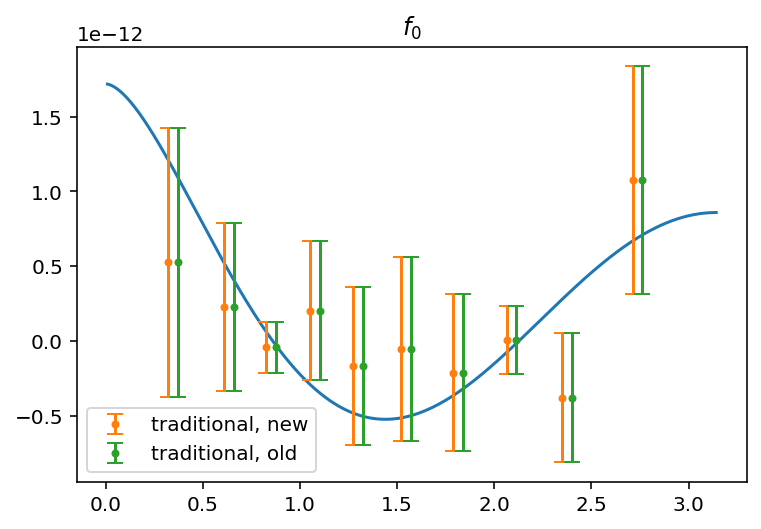

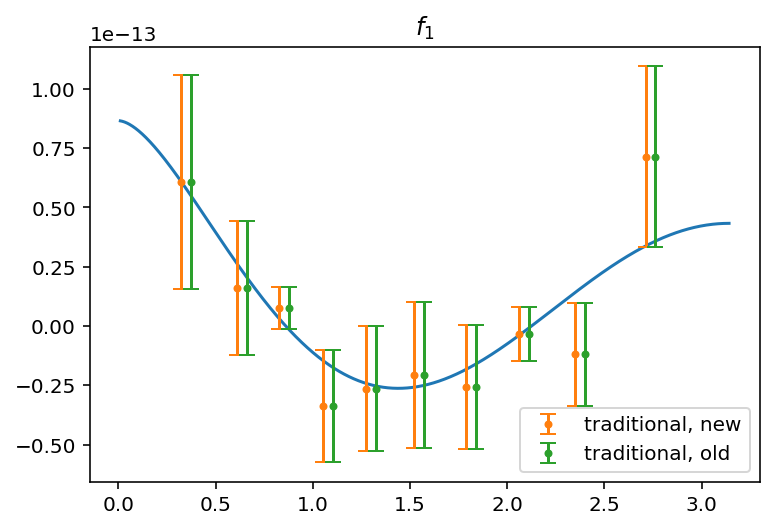

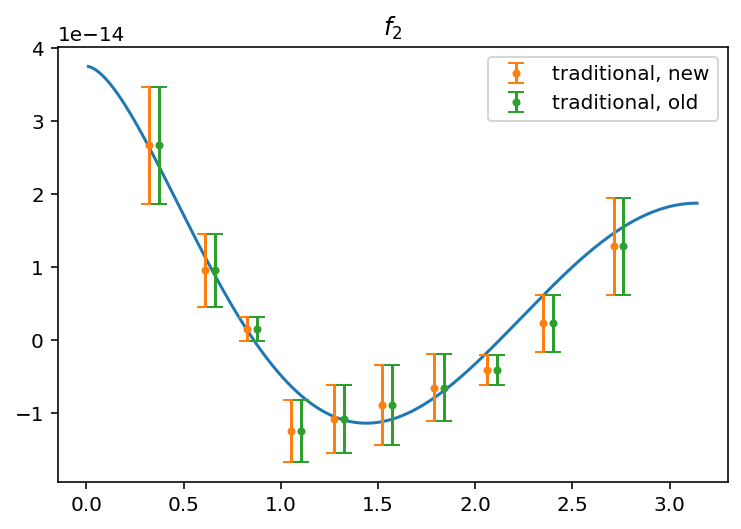

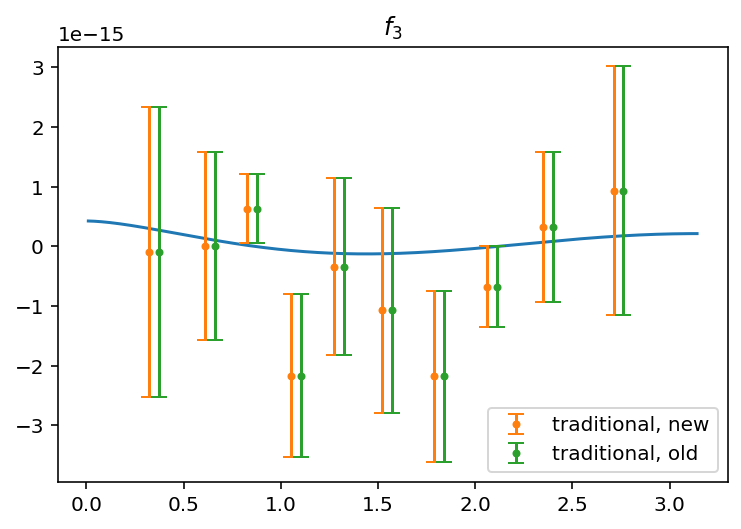

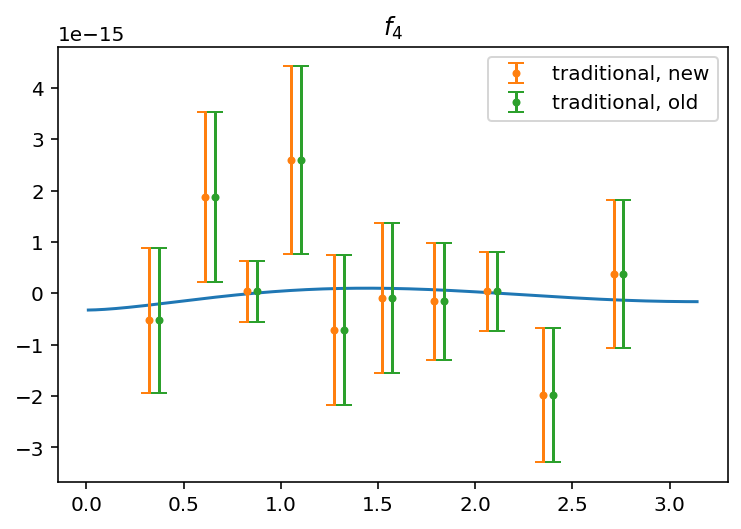

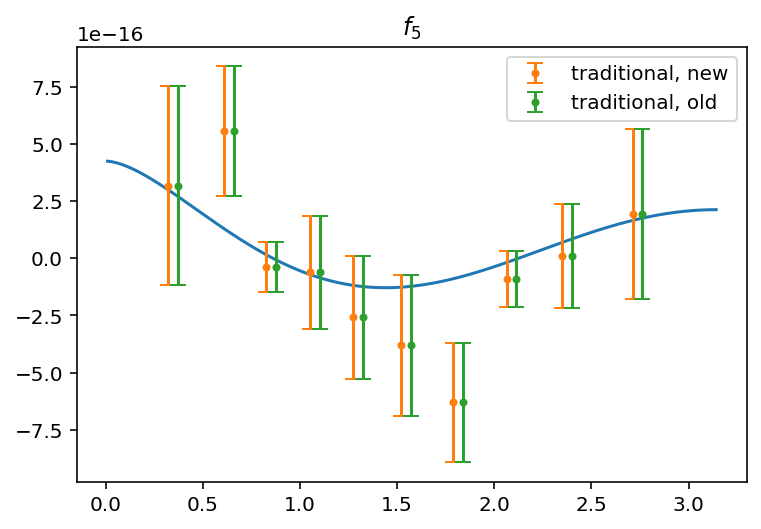

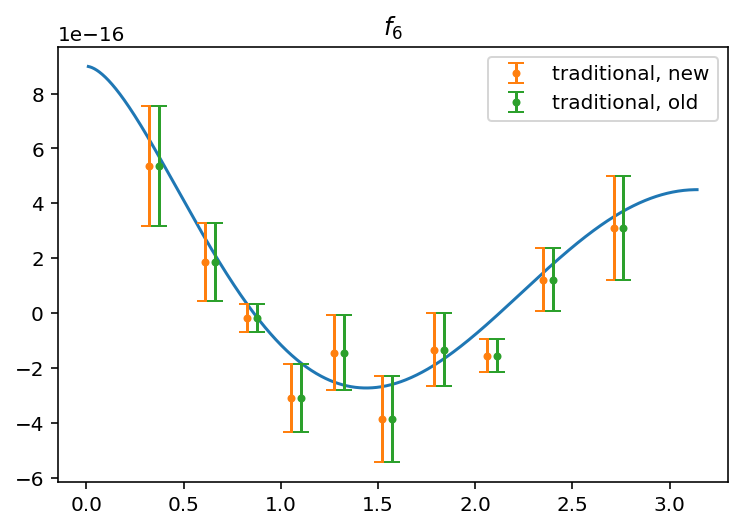

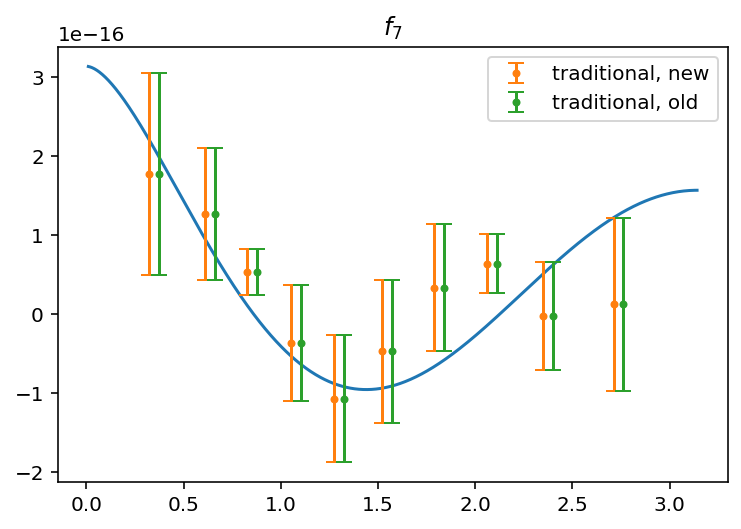

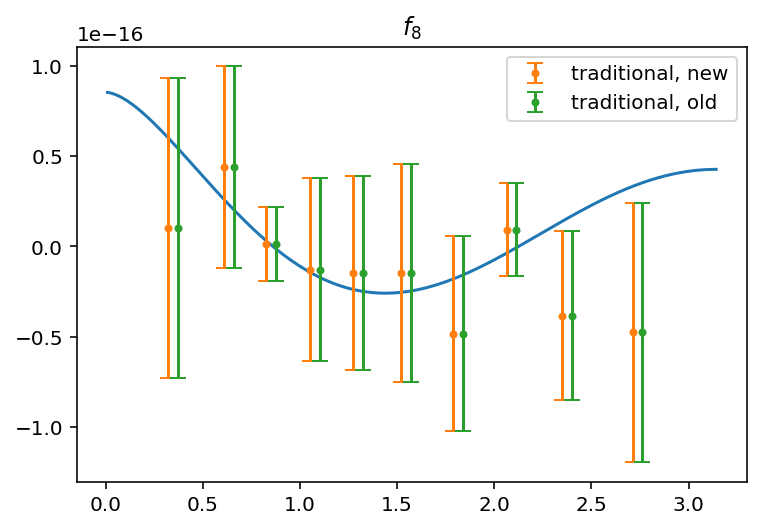

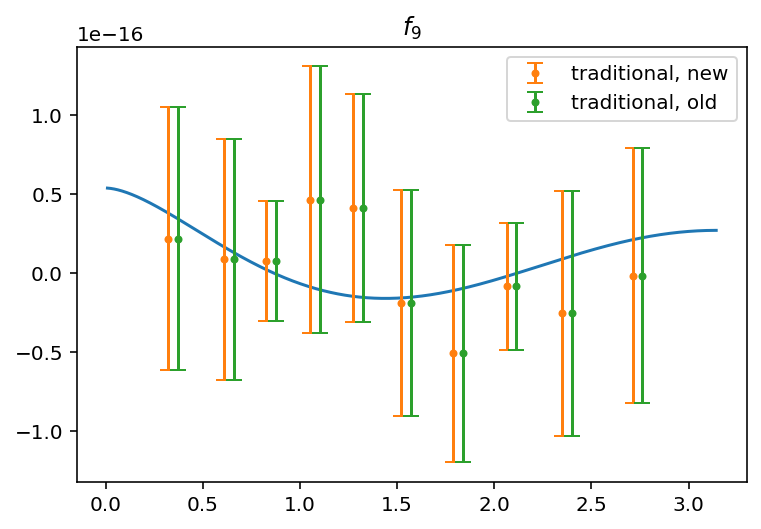

In [80]:
from enterprise_extensions import model_orfs

#old_xi,old_rhok,old_sigk,old_Sk,old_Sks,fgw = pair_covariant_normPFOS(old_os,inj_params)
#xi,rhok,sigk,Ck,Sk,Sks = t1.compute_pfos(inj_params,pair_covariance=True,narrowband=False,save_pair_vals=True)


for k in range(len(t1.freqs)):
    orf_lamb = lambda x: model_orfs.hd_orf([1,0,0], [np.cos(x),np.sin(x),0])
    xi_range = np.linspace(0.01,np.pi,1000)
    cor = np.array([orf_lamb(x) for x in xi_range])
    plt.plot(xi_range,Sk[k]*cor)

    xia,rhoa,siga = utils.binned_pair_covariant_correlations(xi,rhok[k],Ck[k],10)
    plt.errorbar(xia,rhoa,siga,fmt='.',capsize=4,label='traditional, new')

    xia,rhoa,siga = utils.binned_pair_covariant_correlations(old_xi,old_rhok[k],old_sigk[k],10)
    plt.errorbar(xia+0.05,rhoa,siga,fmt='.',capsize=4,label='traditional, old')

    plt.legend()
    plt.title(f'$f_{k}$')
    plt.show()

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


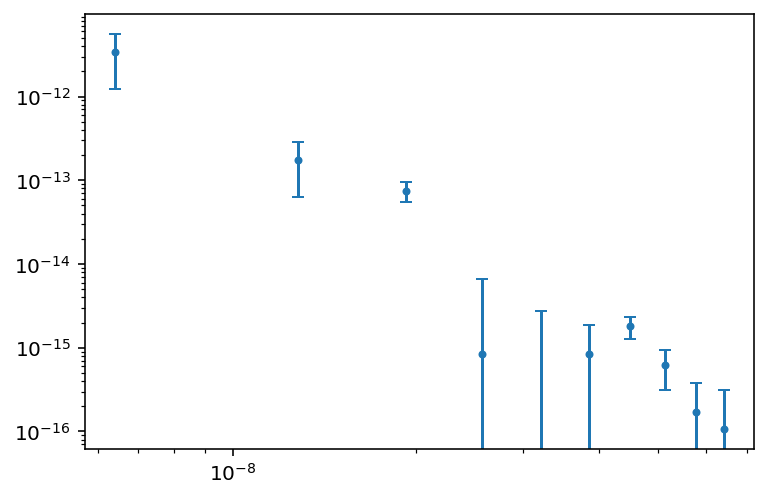

In [20]:
old_xi,old_rhok,old_Ck,old_Sk,old_Sks,fgw = pair_covariant_normPFOS(old_os,inj_params)
plt.errorbar(fgw,old_Sk,old_Sks,fmt='.',capsize=3)
plt.loglog()
plt.show()

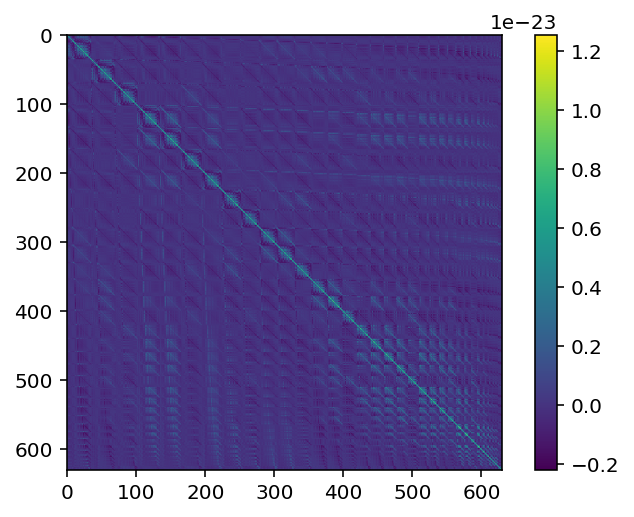

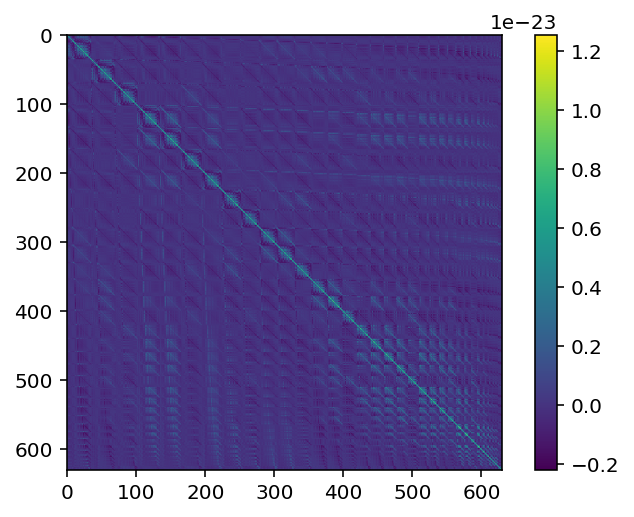

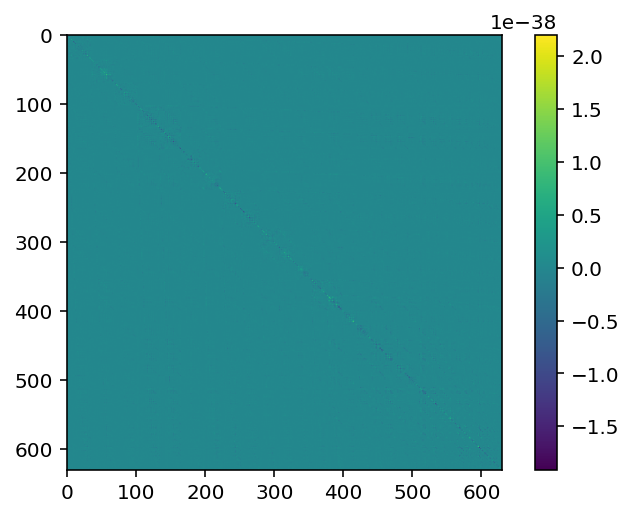

In [21]:
plt.imshow(old_Ck[0])
plt.colorbar()
plt.show()

plt.imshow(Ck[0])
plt.colorbar()
plt.show()

plt.imshow(old_Ck[0]-Ck[0])
plt.colorbar()
plt.show()